In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import webrtcvad
import wave
import speech_recognition as sr           # package SpeechRecognition
import datetime
import strsimpy
import xml.etree.ElementTree as ET
import soundfile as sf

#### Ouverture du csv des annotations, changement des colonnes

In [2]:
samplerate = 16000

directory = './challenge-m2-sid/'
dir_audio = directory + 'corpus/audio/'
dir_texte = directory + 'corpus/text/'
dir_video = directory + 'corpus/video/'

audio_extension = "_mono.wav"
texte_extension = ".xml"
video_extension = ".m4v"

annot = pd.read_csv(directory+'annotations_challenge_sid.csv', sep="\t", index_col=0, header=0).replace(-1,np.nan)
noteurs = annot.columns[1:]

annot['doc']      = ["_".join(e.split("_")[0:2]) for e in annot["code_doc"]]
annot['audio']    = [int(e.split("_")[2][0])     for e in annot["code_doc"]]
annot['video']    = [int(e.split("_")[2][1])     for e in annot["code_doc"]]
annot['texte']    = [int(e.split("_")[2][2])     for e in annot["code_doc"]]
annot['isGraded'] = [int(e.split("_")[3])        for e in annot["code_doc"]]

annot = annot.drop("code_doc", axis=1)
annot.head(6)

il08_09  vg04_05  fd03_04  la09_10  cg13_14  mb00_12    doc  audio  video  \
1      NaN      NaN      NaN      NaN      NaN      NaN  119_8      1      0   
2      NaN      NaN      NaN      NaN      NaN      NaN  119_8      1      1   
3      NaN      NaN      NaN      NaN      NaN      NaN  119_8      1      1   
4      NaN      NaN      NaN      NaN      NaN      NaN  119_8      1      0   
5      NaN      NaN      NaN      NaN      NaN      NaN  119_8      0      0   
6      NaN      NaN      NaN      NaN      NaN     76.0   57_6      1      0   

   texte  isGraded  
1      0         0  
2      0         0  
3      1         0  
4      1         0  
5      1         0  
6      0         1

#### Selection des audio notés et calcul de la moyenne

In [3]:
audio_only = annot[(annot['isGraded'] == 1) &
                   (annot['audio']    == 1) &
                   (annot['video']    == 0) &
                   (annot['texte']    == 0)
                  ].copy()

audio = annot[(annot['isGraded'] == 1) & 
              (annot['audio']    == 1)
             ].copy()

audio['moyenne']      = audio[noteurs].apply(np.nanmean, axis=1)
audio_only['moyenne'] = audio_only[noteurs].apply(np.nanmean, axis=1)

print("audio :",      len(set(audio['doc'])))
print("audio_only :", len(set(audio_only['doc'])))

audio_only[['doc','moyenne']].groupby(['doc']).agg(['count','mean']).head(7)

audio : 55
audio_only : 33


moyenne      
        count  mean
doc                
100_1       1  47.5
107_7       1  76.0
108_3       1  66.0
128_5       1  81.0
13_2        1  62.5
147_1       1  64.0
148_4       1  13.0

#### liste des fichiers audio annotés

In [4]:
ratedScenes = sorted(list(set(audio['doc'])))
print(ratedScenes[0:10])

['100_1', '107_7', '108_3', '116_15', '128_5', '129_5', '12_13', '13_2', '147_1', '148_4']


### Librairies : Pybk, webTRC, SNR, énergie, ZCR, MFCC
score de reconnaissance son texte avec le CMU sphinx  
nombre de locuteurs en tout (et en même temps)  
SNR  
ligth gradient boosting (si pb de corrélation)  
accent ?  
lium speaker diarization (java) -> nombre de locuteur, (~segmentation parole/non parole)  





In [5]:
# loading signal
def load_signal(file, sr=16000):
    signal, fe = librosa.load(file, sr=sr, mono=True)
    
    w = wave.open(file, "rb")
    binary_data = w.readframes(w.getnframes())
    
    return binary_data, signal, fe

# speech detection using webrtcvad
def get_speech_intervals(bin_signal, fe=16000, agg=3, affichage=False):
    recomposed_signal = np.frombuffer(bin_signal, dtype=np.int16)

    vad = webrtcvad.Vad()
    vad.set_mode(mode=agg)

    millisec = 30
    fenetre = int(fe * millisec * 2 / 1000)

    fen_speech = [vad.is_speech(bin_signal[m:m+fenetre], fe) 
                  for m in range(0,len(bin_signal),fenetre)
                 if len(bin_signal[m:m+fenetre]) == fenetre]

    widened_speech = np.array([[s] * int(fenetre/2) for s in fen_speech]).ravel()
    speech = np.full(len(recomposed_signal), widened_speech[-1])
    speech[0:len(widened_speech)] = widened_speech

    # adoucissement sur des fenetres de 1/3 de seconde
    smoothed_speech = pd.Series(speech).rolling(window=int(fe/3), min_periods=2, center=True).mean() > 0.5
    
    if affichage :
        plt.figure(figsize=(14,4))
        plt.plot(np.arange(len(smoothed_speech))/fe, smoothed_speech*max(recomposed_signal), label="speech")
        plt.plot(np.arange(len(recomposed_signal))/fe, recomposed_signal, label="signal")
        plt.xlabel("sec")
        plt.legend(loc=4)
        plt.show()
        
    return smoothed_speech

# SNR using speech detection (bad on recomposed signal from binary)
def get_SNR(signal, speech, fe=16000):
    s = pd.Series(signal)
    energy_total = (s**2).rolling(window=fe, min_periods=2, center=True).mean()

    energy_speech = (s[speech]**2).rolling(window=fe, min_periods=2, center=True).mean()
    energy_notSpeech = (s[~speech]**2).rolling(window=fe, min_periods=2, center=True).mean()

    SNR = energy_speech.mean() / (energy_speech.mean() + energy_notSpeech.mean())
    
    return SNR

# return text sentence from audio
def get_recognition(audiofile, adjust_noise=False):
    r  = sr.Recognizer()
    demo = sr.AudioFile(audiofile)
    with demo as source:
        if adjust_noise: r.adjust_for_ambient_noise(source)
        audio = r.record(source)
    try:
        recon = r.recognize_google(audio, language='fr-FR', show_all=True)
        if len(recon) == 0 :
            text = ''
            conf = 0
        else :
            text = recon['alternative'][0]['transcript']
            conf = recon['alternative'][0]['confidence']
    except LookupError:
        print("LookupError : Could not understand audio")
        text = ''
        conf = 0
    
    return conf, text

# return sentences, when they start in seconds and their length in seconds
def get_timed_sentences(xmlfile):
    tree = ET.parse(xmlfile)

    sentences = [([e.attrib['value'] for e in sent if e.tag=='time'],
                  " ".join([w.text.strip() for w in sent if w.text is not None]))
                 for sent in tree.getroot()]

    t0 = datetime.datetime.strptime(sentences[0][0][0], '%H:%M:%S,%f')
    for i,(t,s) in enumerate(sentences):
        t1 = datetime.datetime.strptime(t[0], '%H:%M:%S,%f')
        t2 = datetime.datetime.strptime(t[1], '%H:%M:%S,%f')
        sentences[i] = (((t1 - t0).total_seconds() , (t2 - t1).total_seconds()),s)

    return sentences

# split tthe speech signal (0/1) into several signal (1)
def split_speech(speech, sr=16000, sec_before=1, sec_after=0.5):
    f = np.array([1,-1])
    r = np.convolve(speech, f, 'same')
    starts, ends = np.where(r == 1)[0].tolist(), np.where(r == -1)[0].tolist()
    if ends[0] < starts[0] : starts = [0] + starts
    if len(starts) > len(ends) : ends = ends + [len(speech)]

    speech_intervals = np.array([(0, starts[i] - int(sr*sec_before), starts[i], ends[i], ends[i] + int(sr*sec_after))
                                 for i in range(len(starts))])

    diffs = [(v[2] - speech_intervals[i][-2] - int(sr*sec_before)) for i,v in enumerate(speech_intervals[1:])]
    diffs = [0 if speech_intervals[0,1] > 0 else -speech_intervals[0,1]] + [0 if v > 0 else abs(v) for v in diffs]

    speech_intervals[:,0] = diffs
    speech_intervals[:,1] += speech_intervals[:,0]
    speech_intervals[speech_intervals < 0] = 0

    df_intervals = pd.DataFrame(speech_intervals,
                                columns=['add_noise','start_signal','start_speech','end_speech','end_signal'])
    return df_intervals

# make the dataframe of features
def make_audio_features(scenes, df=None, sr=16000, by_splitting=True):
    if df is None : df = pd.DataFrame(columns=['SCENE','SPEECH','SNR','RECON','CONF','SCORE','XML'])
    for scene in scenes:
        if scene not in list(df['SCENE']):
            audiofile = dir_audio + scene + audio_extension
            xmlfile  = dir_texte + scene + texte_extension

            # load data
            bin_signal, signal, fe = load_signal(audiofile, sr=sr)

            # speech intervals
            speech = get_speech_intervals(bin_signal, fe=fe, agg=3, affichage=False)
            
            # SNR (from speech data)
            SNR = get_SNR(signal, speech, fe=fe)

            # xml to text
            sentences = get_timed_sentences(xmlfile)
            sent_ponct = " ".join([s[1] for s in sentences])
            sent = " ".join("".join([x if x.isalpha() else " " for x in sent_ponct]).split())
            
            # audio to text
            if not by_splitting:
                overall_conf, overall_text = get_recognition(audiofile)
            else :
                # split speech
                df_intervals = split_speech(speech, sec_before=0.8, sec_after=0.3)

                df_intervals['CONF'] = 0
                df_intervals['RECON'] = ''
                for i in range(len(df_intervals)):
                    signal_interval = signal[df_intervals.loc[i,'start_signal']:df_intervals.loc[i,'end_signal']].astype(np.float32)

                    temp_file = './test.wav'
                    sf.write(temp_file, signal_interval, samplerate=samplerate, subtype='PCM_16')
                    conf, text = get_recognition(temp_file, adjust_noise=False)

                    df_intervals.loc[i,'CONF'] = conf
                    df_intervals.loc[i,'RECON'] = text

                overall_text = " ".join([s.strip() for s in " ".join(df_intervals['RECON'].astype(str).tolist()).split()])
                overall_conf  = df_intervals['CONF'].mean()

            # distance and score
            levenshtein = strsimpy.Levenshtein()
            distance = levenshtein.distance(overall_text.lower(), sent.lower())
            score = distance / len(sent)

            row = pd.Series([scene,
                     speech.sum()/len(speech),
                     SNR,
                     overall_text,
                     overall_conf,
                     score,
                     sent_ponct],
                    index = df.columns)

            df = df.append(row, ignore_index=True)

            print(scene, ":  \t\t",
                  round(speech.sum()*100 / len(speech),2), "% de speech;",
                  "\t SNR  :", round(SNR*100,2), "%;",
                  "\t Score :", round(score*100,2), "; "
                  "\t Conf :", round(overall_conf*100,2))
    return df

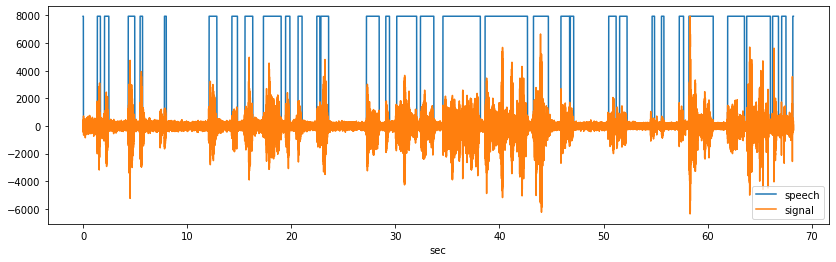

100_1 :		 47.06 % de speech
100_1 :		 SNR  = 95.12 %


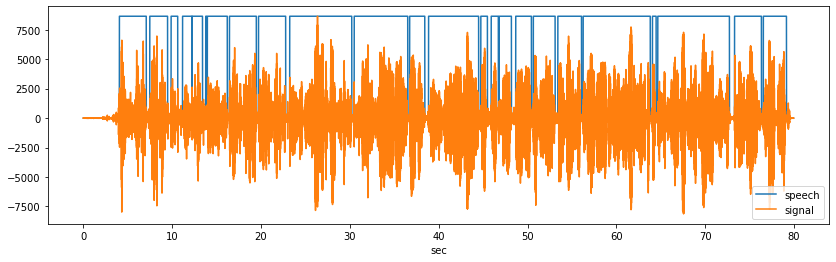

107_7 :		 85.49 % de speech
107_7 :		 SNR  = 99.05 %


In [6]:
ratedScenes = sorted(list(set(audio_only['doc'])))

for scene in ratedScenes[0:2]:
    file = dir_audio + scene + audio_extension
    bin_signal, signal, fe = load_signal(file, sr=samplerate)

    speech = get_speech_intervals(bin_signal, fe=fe, agg=3, affichage=True)
    SNR = get_SNR(signal, speech, fe=fe)

    print(scene, ":\t\t", round(speech.sum()*100 / len(speech),2), "% de speech")
    print(scene, ":\t\t SNR  =", round(SNR*100,2), "%")

In [7]:
scene = '226_6'
file = dir_audio + scene + audio_extension
bin_signal, signal, fe = load_signal(file, sr=samplerate)
Audio(data=signal, rate=fe)

# Tests

#### adding noise at the beginning (better because of noise adjsutement?)

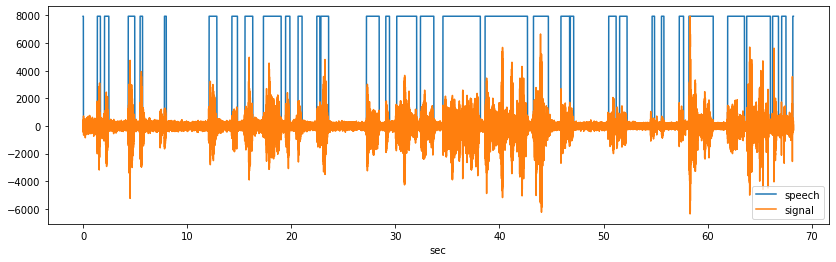

100_1 :		 47.06 % de speech
100_1 :		 SNR  = 95.12 %


In [11]:
file = dir_audio + scene + audio_extension
bin_signal, signal, fe = load_signal(file, sr=samplerate)

speech = get_speech_intervals(bin_signal, fe=fe, agg=3, affichage=True)
SNR = get_SNR(signal, speech, fe=fe)

print(scene, ":\t\t", round(speech.sum()*100 / len(speech),2), "% de speech")
print(scene, ":\t\t SNR  =", round(SNR*100,2), "%")

In [12]:
# return bool signal where the background noise is
def get_background(signal, speech, fe, affichage=False):
    background = speech.rolling(window=int(fe/3), center=True).mean() < 1/100
    
    if affichage:
        plt.figure(figsize=(14,4))
        plt.plot(signal, label="signal")
        plt.plot(speech * max(signal) / 2, label="speech")
        plt.plot(background * max(signal), label="noise")
        plt.legend(loc=4)
        plt.show()
        
    return background

# make noise from signal and background
def make_noise(signal, background, fe, lenght=3):
    noise = np.array([signal[background][m:m+lenght*fe]
                      for m in range(len(signal[background][::lenght*fe]))]).mean(axis=0)
    return noise

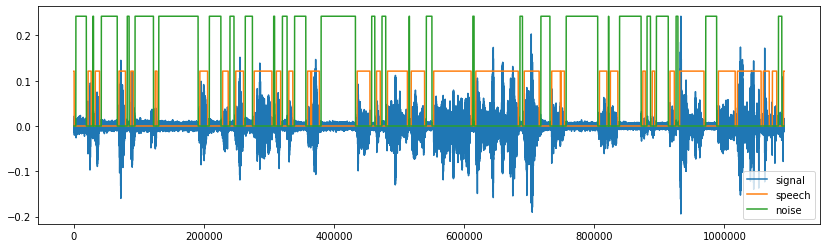

In [13]:
background = get_background(signal, speech, fe, affichage=True)
noise = make_noise(signal, background, fe, lenght=3)

Audio(data=noise, rate=fe)

In [14]:
signalPlusNoise = list(noise)+list(signal)
Audio(data=signalPlusNoise, rate=fe)

#### SNR (crapy for now)

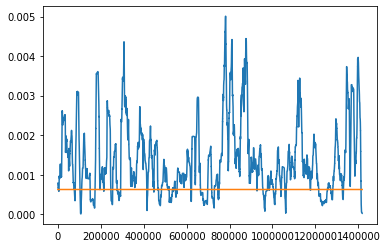

In [15]:
scene = '226_6'
file = dir_audio + scene + audio_extension
signal, fe = librosa.load(file, sr=samplerate, mono=True)

energy = (pd.Series(signal)**2).rolling(window=fe, min_periods=2, center=True).mean()

s = pd.Series(signal)
energy = (s**2).rolling(window=fe, min_periods=2, center=True).mean()
min_E = min(energy)
min_E = np.percentile(energy, 5)
plt.plot(energy)
f = 2
plt.plot([f * min_E] * len(energy))
plt.show()

# Make features

In [8]:
ratedScenes = sorted(list(set(audio_only['doc'])))
df_features = pd.DataFrame(columns=['SCENE','SPEECH','SNR','RECON','CONF','SCORE','XML'])
#df_features = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')

In [9]:
df_features = make_audio_features(ratedScenes, df=df_features, by_splitting=True)
df_features.head()

100_1 :  		 47.06 % de speech; 	 SNR  : 95.12 %; 	 Score : 46.66 ; 	 Conf : 49.77
107_7 :  		 85.49 % de speech; 	 SNR  : 99.05 %; 	 Score : 84.24 ; 	 Conf : 22.62
LookupError : Could not understand audio
LookupError : Could not understand audio
108_3 :  		 57.32 % de speech; 	 SNR  : 93.78 %; 	 Score : 44.4 ; 	 Conf : 54.54
128_5 :  		 57.56 % de speech; 	 SNR  : 98.97 %; 	 Score : 45.03 ; 	 Conf : 49.3
LookupError : Could not understand audio
13_2 :  		 70.93 % de speech; 	 SNR  : 94.9 %; 	 Score : 47.22 ; 	 Conf : 56.03
LookupError : Could not understand audio
147_1 :  		 77.1 % de speech; 	 SNR  : 99.06 %; 	 Score : 54.17 ; 	 Conf : 50.07
LookupError : Could not understand audio
148_4 :  		 52.98 % de speech; 	 SNR  : 99.88 %; 	 Score : 27.98 ; 	 Conf : 53.38
165_10 :  		 81.15 % de speech; 	 SNR  : 98.07 %; 	 Score : 29.15 ; 	 Conf : 32.56
180_4 :  		 72.72 % de speech; 	 SNR  : 98.73 %; 	 Score : 56.6 ; 	 Conf : 55.51
186_2 :  		 33.82 % de speech; 	 SNR  : 89.53 %; 	 Score : 47.

SCENE    SPEECH       SNR  \
0  100_1  0.470615  0.951221   
1  107_7  0.854934  0.990467   
2  108_3  0.573243  0.937837   
3  128_5  0.575551  0.989666   
4   13_2  0.709282  0.948989   

                                               RECON      CONF     SCORE  \
0  Bonsoir pourquoi tu es pas sérieux tu me manqu...  0.497705  0.466595   
1  pour aller plus vite parce que je suis un manu...  0.226204  0.842395   
2  chorale pourrais-tu j'ai totalement à côté de ...  0.545397  0.443959   
3  tu as remarqué comme les mises en clair normal...  0.492977  0.450262   
4  dites-moi Monsieur pires sûrement une petite i...  0.560324  0.472222   

                                                 XML  
0  Bonsoir . Tu veux pas te garer? Pour quoi fair...  
1  Qu'est ce qui se passe ? Vous en faites un bou...  
2  Quoi? Une chorale? Oui . Mon pauvre Mathieu , ...  
3  T’as remarqué comme les nuits sont claires ? N...  
4  Dites-moi , monsieur Pire , Tina Lombardi , vo...

In [10]:
df_features.to_csv('./data/audio_features.csv', sep='§', encoding='utf-8')

#### sur les autres data :

In [240]:
df_features = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')
all_scenes = sorted(list(set(annot['doc'])))

In [265]:
df_features = make_audio_features(all_scenes[0:300], df=df_features, by_splitting=True)
df_features.to_csv('./data/audio_features.csv', sep='§', encoding='utf-8')
print(len(df_features), "/", len(all_scenes))
df_features.head()

82_11 :  		 64.69 % de speech; 	 SNR  : 98.84 %; 	 Score : 54.38 ; 	 Conf : 90.56
83_14 :  		 38.71 % de speech; 	 SNR  : 99.57 %; 	 Score : 65.98 ; 	 Conf : 89.96
84_4 :  		 82.17 % de speech; 	 SNR  : 95.33 %; 	 Score : 56.86 ; 	 Conf : 90.28
85_6 :  		 76.59 % de speech; 	 SNR  : 90.01 %; 	 Score : 50.0 ; 	 Conf : 92.02
86_14 :  		 76.7 % de speech; 	 SNR  : 98.07 %; 	 Score : 62.29 ; 	 Conf : 92.57
87_2 :  		 75.08 % de speech; 	 SNR  : 90.25 %; 	 Score : 20.3 ; 	 Conf : 87.88
88_11 :  		 65.08 % de speech; 	 SNR  : 99.15 %; 	 Score : 72.01 ; 	 Conf : 92.65
89_2 :  		 61.08 % de speech; 	 SNR  : 96.42 %; 	 Score : 10.35 ; 	 Conf : 90.34
8_3 :  		 73.92 % de speech; 	 SNR  : 98.45 %; 	 Score : 99.15 ; 	 Conf : 90.63
90_15 :  		 69.36 % de speech; 	 SNR  : 91.98 %; 	 Score : 18.41 ; 	 Conf : 91.39
91_14 :  		 50.0 % de speech; 	 SNR  : 99.27 %; 	 Score : 100.0 ; 	 Conf : 0
92_4 :  		 90.03 % de speech; 	 SNR  : 93.8 %; 	 Score : 84.94 ; 	 Conf : 89.48
93_8 :  		 53.76 % de speech; 	 

SCENE    SPEECH       SNR  \
0  100_1  0.470615  0.951221   
1  107_7  0.854934  0.990467   
2  108_3  0.573243  0.937837   
3  128_5  0.575551  0.989666   
4   13_2  0.709282  0.948989   

                                               RECON      CONF     SCORE  \
0  Bonsoir je sais pas pourquoi les choses sont d...  0.776671  0.900862   
1        quoi faire pour retrouver la fille de 2 ans  0.912423  0.971094   
2  chorale vous êtes totalement à côté de la plaq...  0.921861  0.810771   
3      marquer comme les mises en clair de la Vierge  0.916613  0.942408   
4  dites-moi monsieur pire c'est la Lombardie vou...  0.898101  0.807407   

                                                 XML  
0  Bonsoir . Tu veux pas te garer? Pour quoi fair...  
1  Qu'est ce qui se passe ? Vous en faites un bou...  
2  Quoi? Une chorale? Oui . Mon pauvre Mathieu , ...  
3  T’as remarqué comme les nuits sont claires ? N...  
4  Dites-moi , monsieur Pire , Tina Lombardi , vo...

# Comparaison

In [11]:
A = pd.read_csv('./data/audio_features.csv', sep='§', engine='python', index_col=0, encoding='utf-8')
B = pd.read_csv('./data/audio_features_old.csv', sep='§', engine='python', index_col=0, encoding='utf-8')

In [40]:
A.head()

SCENE    SPEECH       SNR  \
0  100_1  0.470615  0.951221   
1  107_7  0.854934  0.990467   
2  108_3  0.573243  0.937837   
3  128_5  0.575551  0.989666   
4   13_2  0.709282  0.948989   

                                               RECON      CONF     SCORE  \
0  Bonsoir pourquoi tu es pas sérieux tu me manqu...  0.497705  0.466595   
1  pour aller plus vite parce que je suis un manu...  0.226204  0.842395   
2  chorale pourrais-tu j'ai totalement à côté de ...  0.545397  0.443959   
3  tu as remarqué comme les mises en clair normal...  0.492977  0.450262   
4  dites-moi Monsieur pires sûrement une petite i...  0.560324  0.472222   

                                                 XML  
0  Bonsoir . Tu veux pas te garer? Pour quoi fair...  
1  Qu'est ce qui se passe ? Vous en faites un bou...  
2  Quoi? Une chorale? Oui . Mon pauvre Mathieu , ...  
3  T’as remarqué comme les nuits sont claires ? N...  
4  Dites-moi , monsieur Pire , Tina Lombardi , vo...

In [41]:
B.head()

SCENE    SPEECH       SNR  \
0  100_1  0.470615  0.951221   
1  107_7  0.854934  0.990467   
2  108_3  0.573243  0.937837   
3  128_5  0.575551  0.989666   
4   13_2  0.709282  0.948989   

                                               RECON      CONF     SCORE  \
0  Bonsoir je sais pas pourquoi les choses sont d...  0.776671  0.900862   
1        quoi faire pour retrouver la fille de 2 ans  0.912423  0.971094   
2  chorale vous êtes totalement à côté de la plaq...  0.921861  0.810771   
3      marquer comme les mises en clair de la Vierge  0.916613  0.942408   
4  dites-moi monsieur pire c'est la Lombardie vou...  0.898101  0.807407   

                                                 XML  
0  Bonsoir . Tu veux pas te garer? Pour quoi fair...  
1  Qu'est ce qui se passe ? Vous en faites un bou...  
2  Quoi? Une chorale? Oui . Mon pauvre Mathieu , ...  
3  T’as remarqué comme les nuits sont claires ? N...  
4  Dites-moi , monsieur Pire , Tina Lombardi , vo...

In [39]:
for i in range(len(A)):
    a = A.loc[i,'RECON']
    b = B.loc[i,'RECON']
    print("--------------\n",A.loc[i,'SCENE'],'\n',a,'\n\n',b,'\n')

--------------
 100_1 
 Bonsoir pourquoi tu es pas sérieux tu me manques je dis pas la porte salut c'est les choses sont différentes pourquoi choisis Élisabeth je l'ai dit dès le début j'ai toujours été très clair j'attends que tu me sonnes moi j'avais le droit une pizza de temps en temps un coup à l'arrière d'une bagnole on va pas remettre ça tu as trouvé un mec tu as un bébé avec c'est fermé le vent seulement depuis tout à l'heure je t'aime quand tu reçois une grosse c' est méchant j'ai envie de toi je suis complètement j'ai envoyé la baby-sitter allez viens 

 Bonsoir je sais pas pourquoi les choses sont différentes j'ai envoyé la baby-sitter allez viens 

--------------
 107_7 
 pour aller plus vite parce que je suis un manuel sur le doute le premier parce que j'en ai marre c'est une même pas avec qui pouvait venir chercher plus tard quoi pour retrouver la fille de Guignol je vous en prie je vous interdit de toucher 

 quoi faire pour retrouver la fille de 2 ans 

--------------
 1